# Current Plan
1. Create a function to calculate the distance between descriptions, use that function to naively classify new descriptions. probably looks something like a search function.
2. Grab a text classification model of hugging face and fine-tune it on the dataset.

In [ ]:
# setup requirements, which aren't loading in the venv for some reason
%pip install -r requirements.txt

## Data Preperation

### Cleaning 
The data is already pretty clean as far as non gramatical structures go. Removing all non-alphanumeric characters and lowercasing actually seems to reduce performance a bit on the embedding model, and these characters are allready stripped in the tokenization process for the naive models.

There are some sanitisation libraries around, eg. the NLTK library but i will stick to simple here

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re

with open('data/Datas.csv') as file:
    data = pd.read_csv(file)

#over cleaning the data hurts prerformance 
# Strip non alphanumeric characters and convert to lowercase
data['Description'] = data['Description'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
data['Description'] = data['Description'].apply(lambda x: x.lower())

# 
data['Description'] = data['Description'].apply(lambda x: re.sub(r'&amp;', 'and', x))
data['Description'] = data['Description'].apply(lambda x: re.sub(r' & ', 'and', x))

#honestly it should all just get lost in the sauce 

#save to csv 
data.to_csv('data/cleaned_data.csv', index=False)


### Augmentation/Expansion

### Sampling and splitting

In [15]:
# Split data into training and testing sets in a stratified way
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# handle the case where the minimum class has only 2 samples
data = data.groupby('Category').filter(lambda x: len(x) > 2)


train, test = train_test_split(data, test_size=0.2, stratify=data['Category'], random_state=42)

# Oversample, then undersample the training set
# dict of {class: proportion such that all minor classes make up 10% of the major class}
major_class_counts = train['Category'].value_counts().max()
no_classes = train['Category'].nunique()
target_proportion = 0.5
sampling_strategy = {k: int(major_class_counts*target_proportion/no_classes) for k, v in train['Category'].value_counts().to_dict().items()}
oversampler = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42) # sample strategy represents the target proportion
undersampler = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X_train, y_train = train[['Description']], train['Category']
X_train, y_train = oversampler.fit_resample(X_train, y_train)
X_train, y_train = undersampler.fit_resample(X_train, y_train)

# Split the training set into train, test and val sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=77) # gonna get leakage here


# join back because I don't want to refactor the notebook rn
train = pd.concat([X_train, y_train], axis=1)   
val = pd.concat([X_val, y_val], axis=1)
print(train.shape, val.shape, test.shape)

ValueError: With over-sampling methods, the number of samples in a class should be greater or equal to the original number of samples. Originally, there is 193 samples and 5 samples are asked.

### Tokenization

In [228]:
# Function to measure distance 
from sklearn.feature_extraction.text import TfidfVectorizer
# have a think about whether the data needs cleaning

tfidf = TfidfVectorizer() # use token_pattern to remove punctuation if needed
tfidf.fit(train['Description']) # val set not included here 


TfidfVectorizer()

## 1. Basic SciKitLearn Models

### Investigating cosine similarity

In [37]:
# cosine distance
from sklearn.metrics.pairwise import cosine_similarity

values = cosine_similarity(data_vectorized, data_vectorized) # dist() = x.y / (||x|| * ||y||) or sum(x * y) / (sqrt(sum(x^2)) * sqrt(sum(y^2)))
similarities = pd.DataFrame(values, index=train.index, columns=train.index)

# plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(similarities)

### SKLearn Models
Testing the variety of models, SVM and Naive Bayes worked the best on the raw data, while KNN and RF didn't work as well as expected.
All models suffered from the distibution issue in the datset, only predicting the most common classes (food and entertainment).

In [229]:
from sklearn.metrics import  confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
def evaluate(Y_true, Y_pred, dataset_name="Train"):
    # evaluate using the sklearn functions
    precision = precision_score(Y_true, Y_pred, average='macro') #TP / (TP + FP)
    recall = recall_score(Y_true, Y_pred, average='macro') #TP / (TP + FN)
    f1_macro = f1_score(Y_true, Y_pred, average='macro')
    f1 = f1_score(Y_true, Y_pred, average='weighted')
    accuracy = accuracy_score(Y_true, Y_pred) #(TP + TN) / (TP + FP + FN + TN)
    
    # plot
    print(dataset_name," Precision(macro):", precision)
    print(dataset_name," Recall(macro):", recall)
    print(dataset_name," F1 Score(macro):", f1_macro)
    print(dataset_name," F1 Score(weighted):", f1)
    print(dataset_name," Accuracy:", accuracy)
    
def plot_confusion(Y_true, Y_pred, model, fig_name="confusion.png"):
    confusion = confusion_matrix(Y_true, Y_pred)
    disp = ConfusionMatrixDisplay(confusion, display_labels= model.classes_)
    disp.plot(xticks_rotation=90)
    plt.savefig('analysis/'+fig_name, bbox_inches='tight')
    plt.show()

In [ ]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# setup KNN
k = int(np.sqrt(train['Category'].count())) # sqrt(n) is a common choice for k
knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
knn.fit(tfidf.transform(train['Description']).toarray(), train['Category'])

# predict
val_hat = knn.predict(tfidf.transform(val['Description']).toarray())

# evaluate
#evaluate(train['Category'], knn.predict(tfidf.transform(train['Description']).toarray()), "Test")
evaluate(val['Category'], val_hat, "Val")
plot_confusion(val['Category'], val_hat, knn, "confusion_matricies/knn.png")

In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# setup RF
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(tfidf.transform(train['Description']).toarray(), train['Category'])

# predict
train_hat = rf.predict(tfidf.transform(train['Description']).toarray())
val_hat = rf.predict(tfidf.transform(val['Description']).toarray())

# evaluate
evaluate(train['Category'], train_hat, "Test")
evaluate(val['Category'], val_hat, "Val")
plot_confusion(val['Category'], val_hat, rf, "confusion_matricies/rf.png")

In [ ]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# setup NB
nb = MultinomialNB()
nb.fit(tfidf.transform(train['Description']).toarray(), train['Category'])

# predict
train_hat = nb.predict(tfidf.transform(train['Description']).toarray())
val_hat = nb.predict(tfidf.transform(val['Description']).toarray())

# evaluate
evaluate(train['Category'], train_hat, "Test")
evaluate(val['Category'], val_hat, "Val")
plot_confusion(val['Category'], val_hat, nb, "confusion_matricies/nb.png")

Test  Precision(macro): 1.0
Test  Recall(macro): 1.0
Test  F1 Score(macro): 1.0
Test  F1 Score(weighted): 1.0
Test  Accuracy: 1.0
Val  Precision(macro): 0.008264462809917356
Val  Recall(macro): 0.09090909090909091
Val  F1 Score(macro): 0.015151515151515154
Val  F1 Score(weighted): 0.015151515151515154
Val  Accuracy: 0.09090909090909091


/home/james/projects/categoryPrediction/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


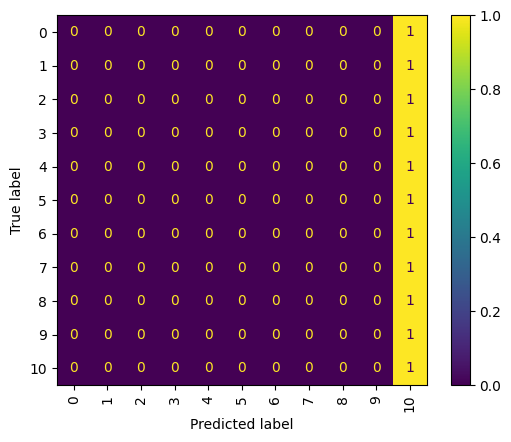

In [230]:
# SVM
from sklearn.svm import SVC

# prepare data labels to be numerical
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['Category'])
train_Y = le.transform(train['Category'])
val_Y = le.transform(val['Category'])

# setup SVM
svm = SVC(kernel='linear')
svm.fit(tfidf.transform(train['Description']).toarray(), train_Y)

# predict
train_hat = svm.predict(tfidf.transform(train['Description']).toarray())
val_hat = svm.predict(tfidf.transform(val['Description']).toarray())

# evaluate
evaluate(train_Y, train_hat, "Test")
evaluate(val_Y, val_hat, "Val")
plot_confusion(val_Y, val_hat, svm, "confusion_matricies/svm.png")

## 2. HuggingFace Models

### Embedding

In [ ]:
%pip install -U sentence-transformers

In [231]:
# MiniLM encoding; full guide: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
import pandas as pd 
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(train['Description'].values)

assert len(embeddings) == train['Description'].count() 

### Basic Models on Embeddings

In [ ]:
# KNN on embeddings
from sklearn.neighbors import KNeighborsClassifier

# setup KNN
k = int(np.sqrt(train['Category'].count())) # sqrt(n) is a common choice for k
knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
knn.fit(embeddings, train['Category']) # should still have the same indicies

# predict
train_hat = knn.predict(model.encode(train['Description'].values))
val_hat = knn.predict(model.encode(val['Description'].values))

# evaluate
#evaluate(train['Category'], train_hat, "Test")
evaluate(val['Category'], val_hat, "Val")
plot_confusion(val['Category'], val_hat, knn, "confusion_matricies/knn_embeddings.png")

/home/james/projects/categoryPrediction/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val  Precision(macro): 0.1590909090909091
Val  Recall(macro): 0.2727272727272727
Val  F1 Score(macro): 0.18787878787878787
Val  F1 Score(weighted): 0.18787878787878787
Val  Accuracy: 0.2727272727272727


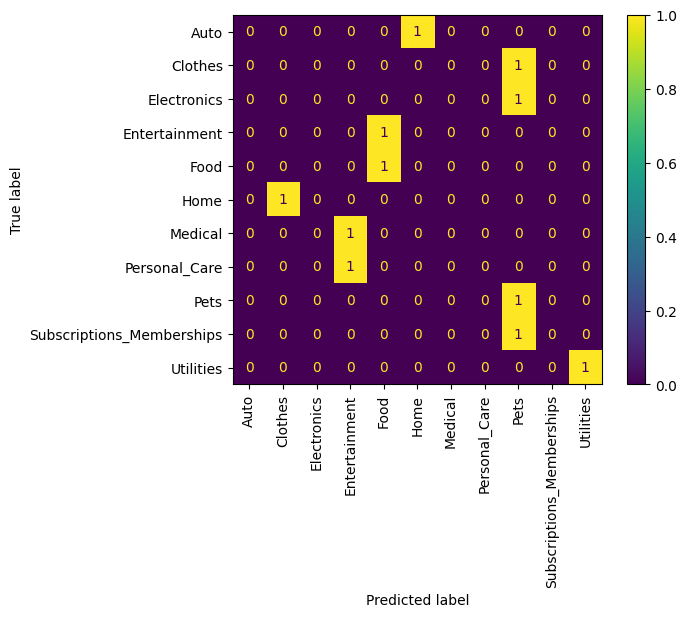

In [232]:
# SVM on embeddings
from sklearn.svm import SVC

# setup SVM
svm = SVC(kernel='linear')
svm.fit(embeddings, train['Category'])

# predict
val_embeddings = model.encode(val['Description'].values)
train_hat = svm.predict(embeddings)
val_hat = svm.predict(val_embeddings)

# Evaluate
#evaluate(train['Category'], train_hat, "Test")
evaluate(val['Category'], val_hat, "Val")
plot_confusion(val['Category'], val_hat, knn, "confusion_matricies/svm_embeddings.png")